### Import Libraries and Data ###

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
path = 'h:/Time Series Data/'
os.chdir(path)
dataset = pd.read_csv('bitcoin_hist_prices.csv')
dataset.shape

(2042, 13)

### EDA ###

#### Data Structure

In [79]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   slug         2042 non-null   object 
 1   symbol       2042 non-null   object 
 2   name         2042 non-null   object 
 3   date         2042 non-null   object 
 4   ranknow      2042 non-null   int64  
 5   open         2042 non-null   float64
 6   high         2042 non-null   float64
 7   low          2042 non-null   float64
 8   close        2042 non-null   float64
 9   volume       2042 non-null   float64
 10  market       2042 non-null   float64
 11  close_ratio  2042 non-null   float64
 12  spread       2042 non-null   float64
dtypes: float64(8), int64(1), object(4)
memory usage: 207.5+ KB


**Number of Unique Values in Each Categorical Column**

In [80]:
cat_cols = dataset.select_dtypes(include='object').columns.to_list()
for col in cat_cols:
    print(len(dataset[col].unique()))

1
1
1
2042


In [81]:
dataset['date'] = pd.to_datetime(dataset['date']) #Convert to datetime format
dataset.set_index('date',inplace=True) # Changing the date column to index

In [82]:
dataset.columns

Index(['slug', 'symbol', 'name', 'ranknow', 'open', 'high', 'low', 'close',
       'volume', 'market', 'close_ratio', 'spread'],
      dtype='object')

**We will do TSA for the closing between prices 2016 and 2018, so we split the data set and remove the redundant columns**

In [102]:
bit_df = dataset['2015-08-01':'2018-08-30'].copy()
bit_df.drop(['slug', 'symbol', 'name','ranknow', 'open', 'high', 'low','volume',
             'market', 'close_ratio', 'spread'],axis=1,inplace=True)
bit_df.shape

(1126, 1)

#### Trends

*Simple Moving Average - SMA: It calculates the unweighted mean of the previous m or n points. 
Typically, it is used to determine the direction of trend in the time series.*

Text(0, 0.5, 'Price')

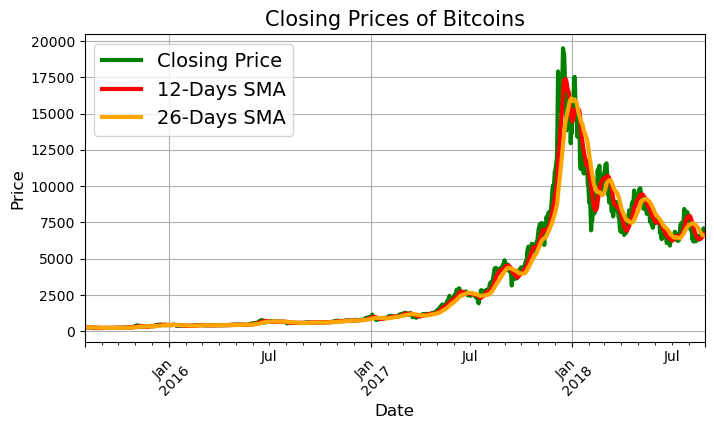

In [103]:
bit_df['5day_SMA'] = bit_df['close'].rolling(12, min_periods=1).mean()
bit_df['10day_SMA'] = bit_df['close'].rolling(26, min_periods=1).mean()

# Grean = Closing Price, RED = 12 Days, ORANG = 26 Days
colors = ['green', 'red', 'orange']

# Line plot 
bit_df.plot(color=colors, linewidth=3, figsize=(8,4))
plt.grid()
plt.xticks(fontsize=10, rotation = 45)
plt.yticks(fontsize=10)
plt.legend(labels =['Closing Price', '12-Days SMA', '26-Days SMA'], fontsize=14)
plt.title('Closing Prices of Bitcoins', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

*Cumulative Moving Average - CMA: It is unweihted mean of past prices till current time.*

Text(0, 0.5, 'Price')

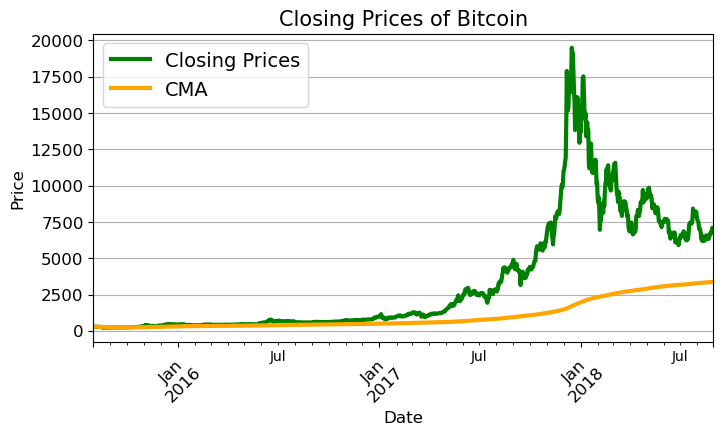

In [104]:
bit_df['CMA'] = bit_df['close'].expanding().mean()

colors = ['green', 'orange']

# line plot
bit_df[['close', 'CMA']].plot(color=colors, linewidth=3, figsize=(8,4))
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)
plt.legend(labels =['Closing Prices', 'CMA'], fontsize=14)
plt.title('Closing Prices of Bitcoin', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

*Exponential Moving Average (EMA): Unlike SMA and CMA, It gives more weight to the recent values. \
It is used to identify trend and filter out noise.*

Text(0, 0.5, 'Price')

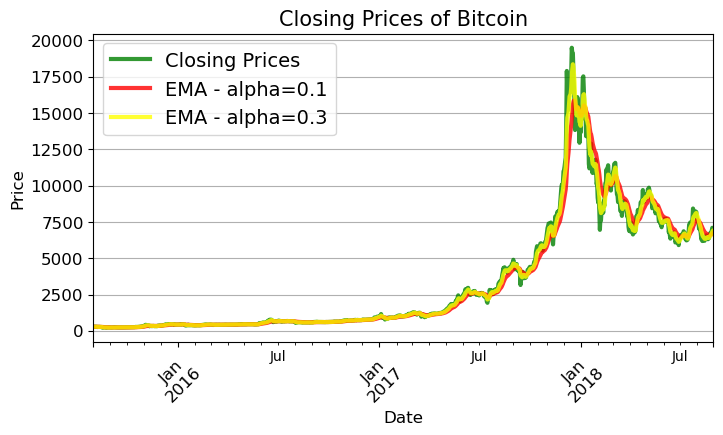

In [105]:
# EMA Air Temperature
# Let's smoothing factor - 0.1
bit_df['EMA_0.1'] = bit_df['close'].ewm(alpha=0.1, adjust=False).mean()
# Let's smoothing factor  - 0.3
bit_df['EMA_0.3'] = bit_df['close'].ewm(alpha=0.3, adjust=False).mean()

# green - Avg Air Temp, red- smoothing factor - 0.1, yellow - smoothing factor  - 0.3
colors = ['green', 'red', 'yellow']
bit_df.loc[:,['close', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, linewidth=3, figsize=(8,4), alpha=0.8)
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)
plt.legend(labels=['Closing Prices', 'EMA - alpha=0.1', 'EMA - alpha=0.3'], fontsize=14)
plt.title('Closing Prices of Bitcoin', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

#### Check for Stationarity

*Staionarity can be checked by visualization or performing an Augmented Dickey-Fuller (ADF) test*\
**1. p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.**
<br>
**2. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.** \
*If the time series is not stationary, try differencing the time series and check its stationarity again.*

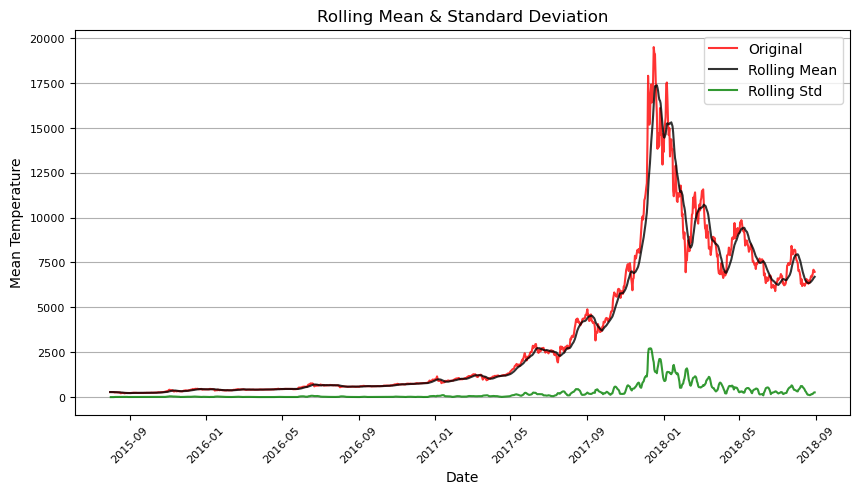

In [106]:
def check_mean_std(series):
    #Rolling statistics
    rolmean = series.rolling(12, min_periods=1).mean()
    rolstd = series.rolling(12, min_periods=1).std()
    plt.figure(figsize=(10,5)) 
    plt.grid(axis='y')
    orig = plt.plot(series, color='red',label='Original', alpha=0.80)
    mean = plt.plot(rolmean, color='black', label='Rolling Mean', alpha=0.80)
    std = plt.plot(rolstd, color='green', label = 'Rolling Std', alpha=0.80)
    plt.xticks(fontsize=8, rotation = 45)
    plt.yticks(fontsize=8)
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
check_mean_std(bit_df['close'])

In [107]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("Stationary")
    else:
        print("Non-Stationary")
check_stationarity(bit_df['close'])

ADF Statistic: -1.600360
p-value: 0.483413
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-Stationary


*Since the data is non-stationary, we need to make it stationary.* \
*First, we need to solve the trend problem. We can use the moving average to solve the trend problem.*

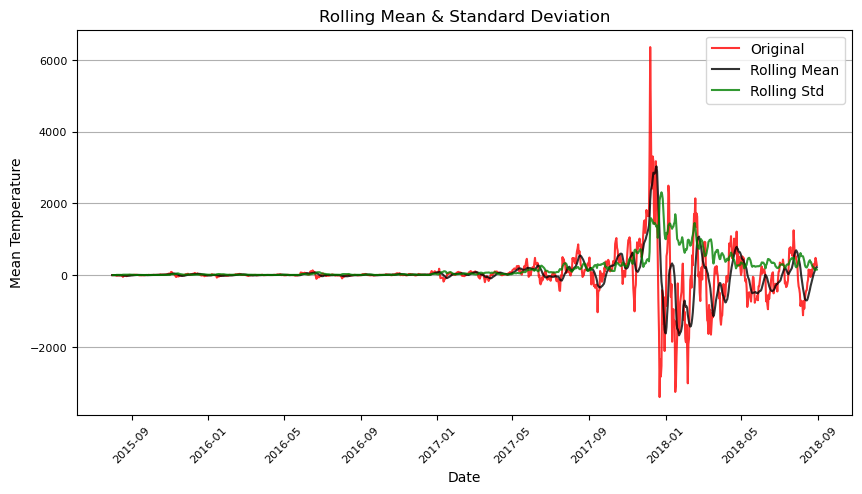

In [108]:
bit_df_moving_average_diff = bit_df['close'] - bit_df['close'].rolling(12, min_periods=1).mean()
check_mean_std(bit_df_moving_average_diff)

In [109]:
check_stationarity(bit_df_moving_average_diff)

ADF Statistic: -6.652360
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


*Another Technique to avoid trend and seasonality is the differencing technique.*

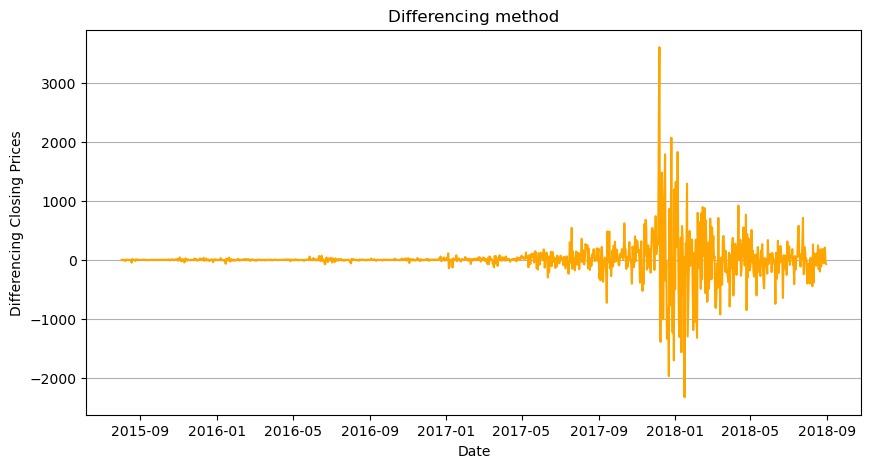

In [110]:
bit_close_price_diff = bit_df['close'] - bit_df['close'].shift()
bit_close_price_diff.dropna(inplace=True) # due to shifting there is nan values
plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.plot(bit_close_price_diff, color='orange')
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Closing Prices")
plt.show()

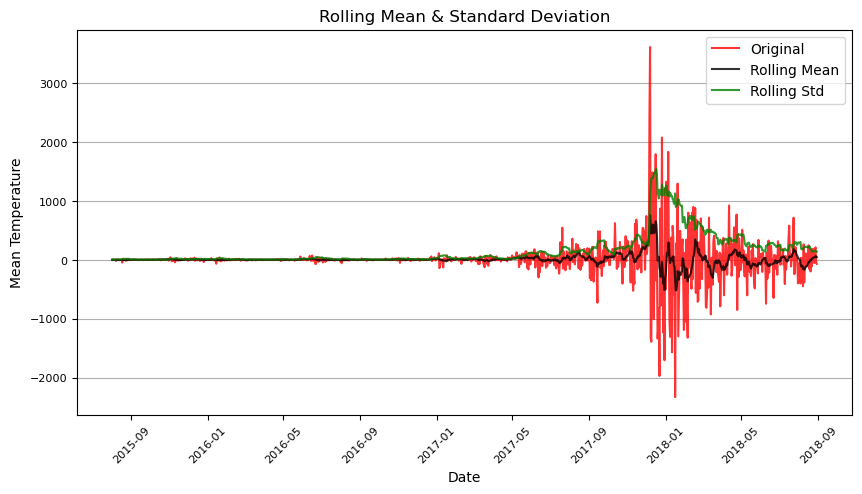

ADF Statistic: -6.185709
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


In [111]:
check_mean_std(bit_close_price_diff)
check_stationarity(bit_close_price_diff)

#### Forecasting

*For forecasting, we will use the ARIMA method. ARIMA stands for Auto-Regressive Integrated Moving Average.* \
- AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
- I: Integrated (d): These are the number of nonseasonal differences. For example, in our case we take the first order difference. So we pass that variable and put d=0
- MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.
- (p,d,q) is parameters of ARIMA model. In order to choose p,d,q parameters we will use two different plots.
    - Autocorrelation Function (ACF): Measurement of the correlation between time series and lagged version of time series.
    - Partial Autocorrelation Function (PACF): This measures the correlation between the time series and lagged version of time series but after eliminating the variations already explained by the intervening comparisons.

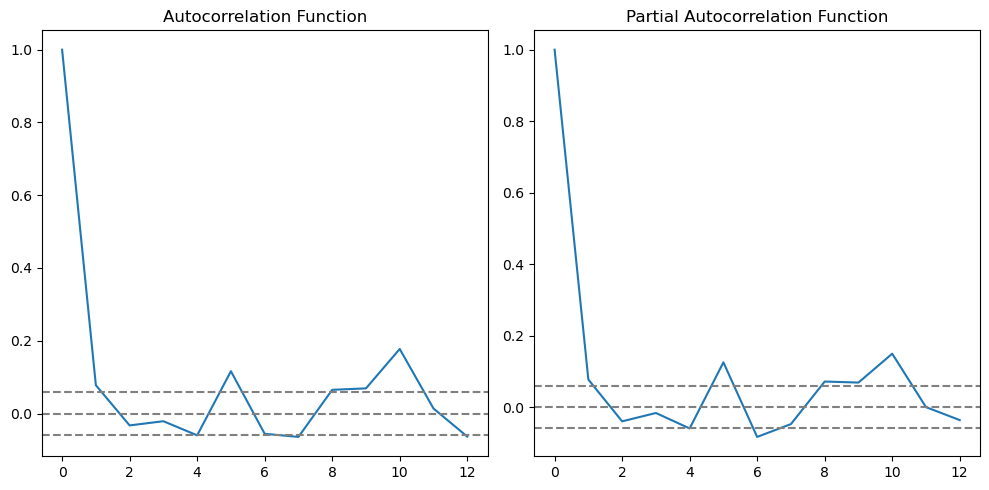

In [112]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(bit_close_price_diff, nlags=12)
lag_pacf = pacf(bit_close_price_diff, nlags=12, method='ols')
length = len(bit_close_price_diff)

# ACF
plt.figure(figsize=(10,5))
plt.grid(axis='x')
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(length),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(length),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(length),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(length),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

- Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values
    - Choosing p: The lag value where the PACF chart crosses the upper confidence interval for the first time. p=1.
    - Choosing q: The lag value where the ACF chart crosses the upper confidence interval for the first time. q=1.
- Now lets use (1,0,1) as parameters of ARIMA models and predict
    - ARIMA: from statsmodels libarary
    - datetime: we will use it start and end indexes of predict method

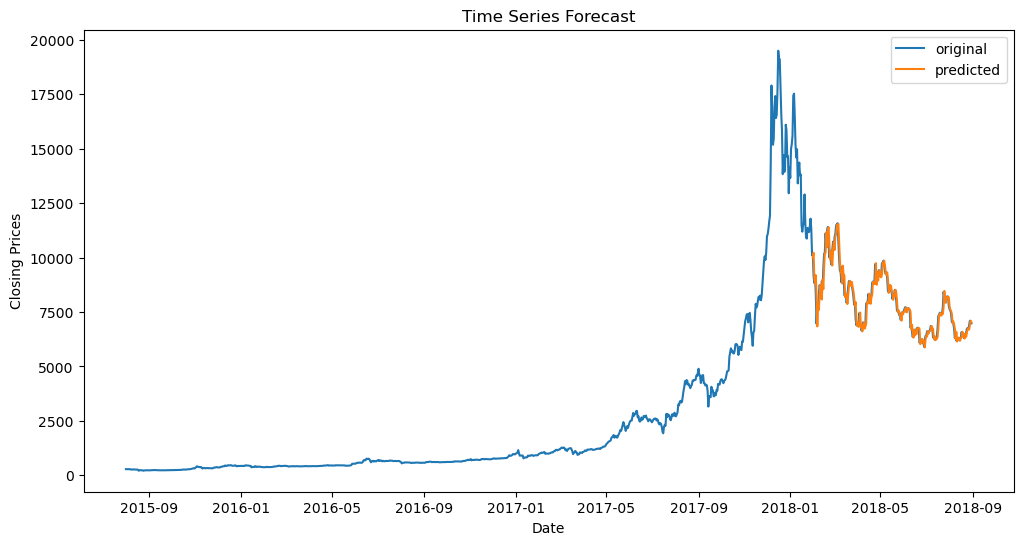

In [98]:
# ARIMA LİBRARY
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

bit_df.index.freq = 'D'

# fit model
model = ARIMA(bit_df['close'], order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit()

# predict
start_index = datetime(2018, 1, 31)
end_index = datetime(2018, 8, 30)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(12,6))
plt.plot(bit_df['close'].index,bit_df['close'].values,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.legend()
plt.show()

error:  105317.59253427312


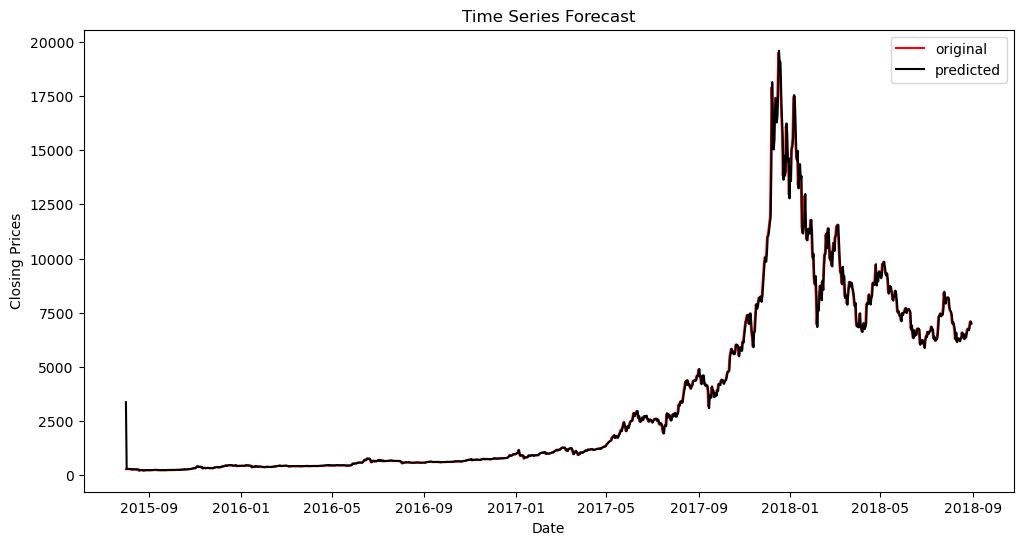

In [99]:
# predict all path
from sklearn.metrics import mean_squared_error
# fit model
model2 = ARIMA(bit_df['close'], order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit2 = model2.fit()
forecast2 = model_fit2.predict()
error = mean_squared_error(bit_df['close'], forecast2)
print("error: " ,error)
# visualization
plt.figure(figsize=(12,6))
plt.plot(bit_df['close'].index,bit_df['close'].values,color = 'red', label = "original")
plt.plot(forecast2,label = "predicted", color = 'black')
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.legend()
# plt.savefig('graph.png')

plt.show()

#### Insights
- We learned that the historical bitcoin prices are non-stationary. 
- From 2017, the bitcoin prices started to rise, and the price rose significantly until January, 2018, with seasonal decrease. 
- Since January, 2018, the price started to fall, with seasonal increase. 